# Téléchargement des librairies

In [45]:
import pandas as pd
import numpy as np
import os

# ACP
import sklearn.decomposition as sd
import sklearn.preprocessing as sp

# Hierarchical clustering
import scipy.cluster.hierarchy as sch
#Wavelet
import pywt
from pywt import wavedec
from statsmodels.robust import mad
# LOF
import sklearn.neighbors as sn
# Isolation Forest
import sklearn.ensemble as se
#One Class SVM
import sklearn.svm as ssvm

# Plot et Display
from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sb
sb.set()
sb.set_style("darkgrid", {"axes.facecolor": ".9"})

# Lecture des données

On lit directement les données nettoyées et dont la longueur a été modifiée à 1024.

In [7]:
import pickle
with open('X_1024', 'rb') as fichier:
    mon_depickler = pickle.Unpickler(fichier)
    X_1024 = mon_depickler.load()
n=len(X_1024) #nb de signaux

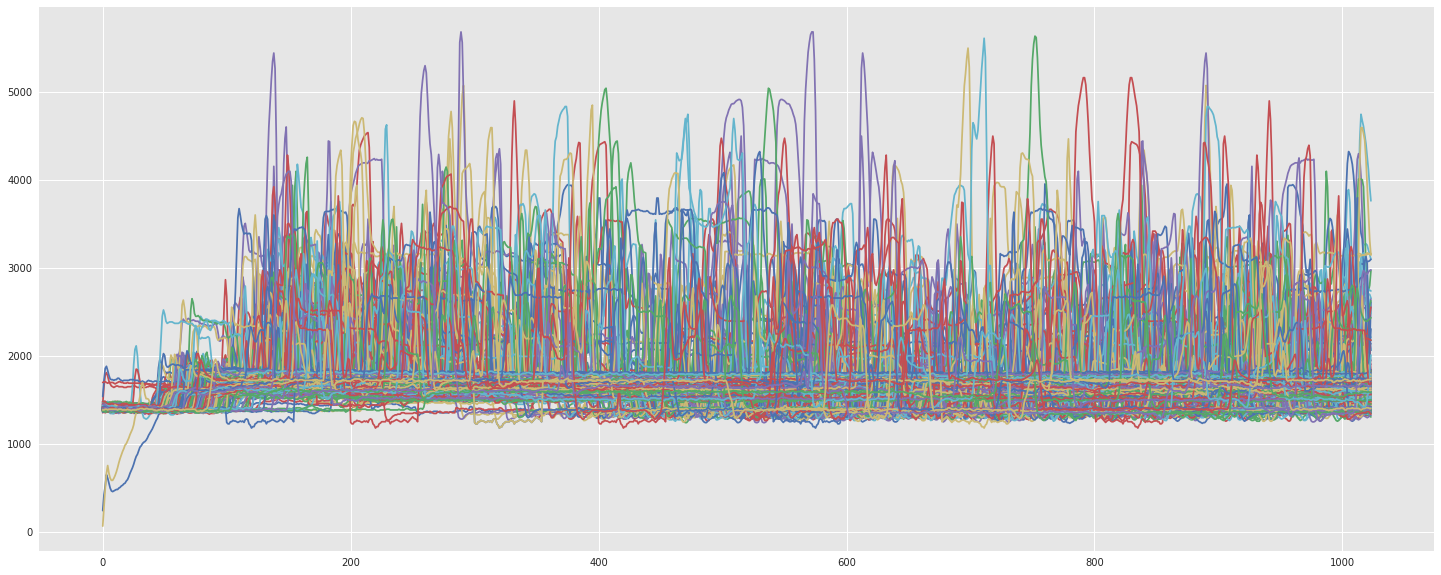

In [8]:
fig = plt.figure(figsize=(25, 10))
for x in X_1024:
    plt.plot(x)

# Décomposition en ondelettes

On effectue la décomposition en ondelettes pour chaque signal et on récupère 2 tableaux de coefficients, l'un avec tous les coefficients de chaque signal, l'autre avec les coefficients seuillés. On pourra réaliser la décomposition en ondelettes seuillés avec les modes `hard`, `soft`, `greater` ou `less`.

In [9]:
wf = "haar"

Coeff = []
TCoeff = []

for x in X_1024:
    #Apply wavelet decomposition
    coeffs = pywt.wavedec(x,wf,level=8)  #Niveau 8
    coeffs_flatten = np.hstack(coeffs)
    Coeff.append(coeffs_flatten)
    # Compute universal Threshold http://jseabold.net/blog/2012/02/23/wavelet-regression-in-python/
    sigma = mad(coeffs[-1])
    uthresh = sigma*np.sqrt(2*np.log(np.shape(x))) #np.log(256) ?
    # Apply Threshold on 4 first levels
    coeffs_thresh = [pywt.threshold(c, uthresh, mode="hard") if j<=3 else c for j,c in enumerate(coeffs[::-1])]
    coeffs_thresh_flatten = np.hstack(coeffs_thresh[::-1])
    TCoeff.append(coeffs_thresh_flatten)
    
Coeff = np.array(Coeff)
TCoeff = np.array(TCoeff)
print(Coeff.shape, TCoeff.shape)
print(np.sum(Coeff!=0), np.sum(TCoeff!=0))

(425, 1024) (425, 1024)
304114 137127


Q : QUEL CHOIX DE NIVEAU (ici 8)? QUEL MODE DE SEUILLAGE ?

## Choix des coefficients

Tous les signaux n'étant pas de même longueur, on est obligé de tronquer chaque signal pour réaliser l'ACP. On choisit d'abord autant de coefficients que la longueur du plus petit signal. Puis, on sélectionne une taille égale à la puissance de 2 la plus grande possible afin de rester dans une même base d'ondelette. 

---> A CONFIRMER

In [10]:
longueur_max = min([len(x) for x in Coeff])
longueur_max=int(2**np.floor(np.log2(longueur_max)))
print(longueur_max)

1024


In [11]:
Coeff = np.array([x[:longueur_max] for x in Coeff])
TCoeff = np.array([x[:longueur_max] for x in TCoeff])

In [12]:
print(Coeff.shape, TCoeff.shape)
print(np.sum(Coeff!=0), np.sum(TCoeff!=0))

(425, 1024) (425, 1024)
304114 137127


On seuille le tableau de coefficients afin de garder seulement les 10% les plus important. 

---> PAS UTILE CAR SEUILLAGE DEJA FAIT AVEC LES TCoeff ???

In [13]:
#N=int(0.1*long_max) #10% coeffs les plus importants
#Coeff_N = np.zeros((n,long_max))
#TCoeff_N = np.zeros((n,long_max))
#for i in range(n):
#    #Coeff
#    ind=np.argsort(Coeff[i,:],axis=None)[::-1] #on trie du plus grand coeff au plus petit
#    ind=ind[0:N] #on recupere les indices des 10% plus grands coeffs
#    for j in range(long_max):
#        if j in ind:
#            Coeff_N[i,j] = Coeff[i,j] #on ne garde que les 10%
#    #TCoeff
#    ind=np.argsort(TCoeff[i,:],axis=None)[::-1] #on trie du plus grand coeff au plus petit
#    ind=ind[0:N] #on recupere les indices des 10% plus grands coeffs
#    for j in range(long_max):
#        if j in ind:
#            TCoeff_N[i,j] = TCoeff[i,j] #on ne garde que les 10%
#            
##Si on souhaite garder tous les coefficients, il suffit de commenter les 2 lignes suivantes            
#Coeff=Coeff_N
#TCoeff=Coeff_N

# Analyse en composantes principales sur les coefficients d'ondelettes

## Fonction d'affichage

In [14]:
def plot_ACP(Coeff):
    #Calcul de l'ACP
    acp = sd.PCA()
    X_acp_ond = acp.fit_transform(sp.scale(Coeff))
    
    #Affichage pourcentage variance expliquee + distribution des premieres composantes
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1,2,1)
    ax.bar(range(10), acp.explained_variance_ratio_[:10]*100, align='center', color='grey', ecolor='black')
    ax.set_xticks(range(10))
    ax.set_ylabel("Variance")
    ax.set_title("Pourcentage de variance expliquee \n des premieres composantes", fontsize=20)

    ax = fig.add_subplot(1,2,2)
    box=ax.boxplot(X_acp_ond[:,0:10])
    ax.set_title("Distribution des premieres composantes", fontsize=20)
    
    #Affichage projection des individus
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1,1,1)
    dict_color = {True : "blue", False : "red"}

    for x,y,s in zip(X_acp_ond[:,0], X_acp_ond[:,1], range(n)):
        ax.plot(x,y,marker=".",color=dict_color[s<300])
        ax.text(x, y, str(s))
    
    ax.set_title("Projection des invididus sur les \n  deux premieres composantes", fontsize=20)

    legend_elements = [Line2D([0], [0], marker='.', color='blue', label='Série du jeu d\'apprentissage', markersize=10, linewidth=0),
                       Line2D([0], [0], marker='.', color='red', label='Série du jeu de test', markersize=10, linewidth=0)]

    ax.legend(handles=legend_elements)

    plt.show()
    

## ACP des coefficients d'ondelettes

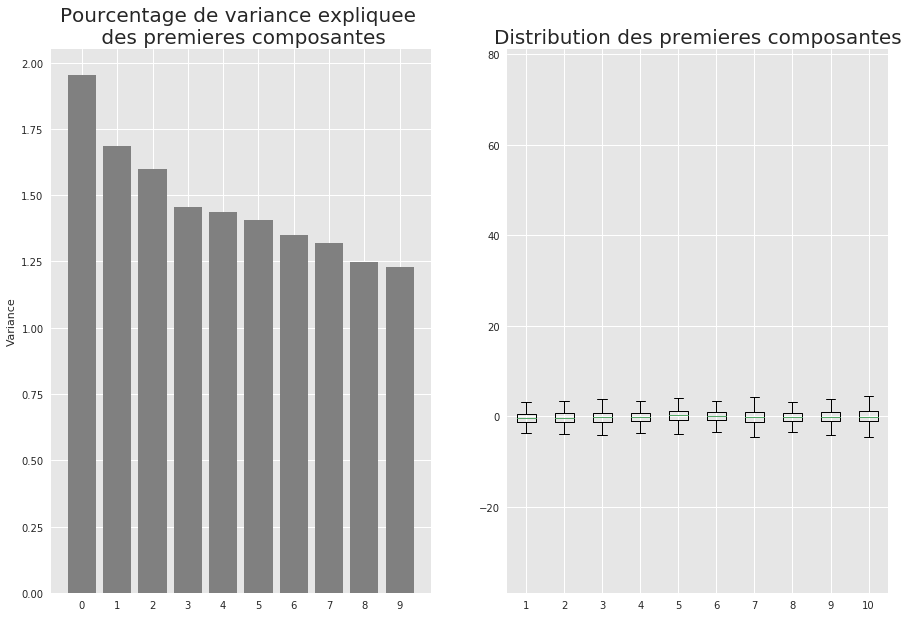

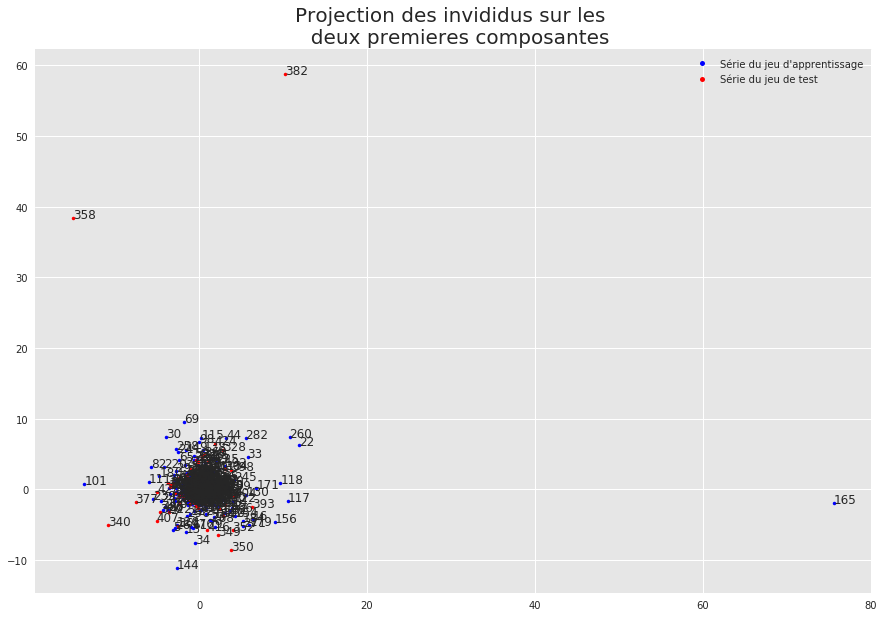

In [15]:
plot_ACP(Coeff)

## Ondelettes de niveau le plus fin J=7 

In [16]:
#Coefficient de niveau 7 : 
Coeff7=Coeff[:,128:]

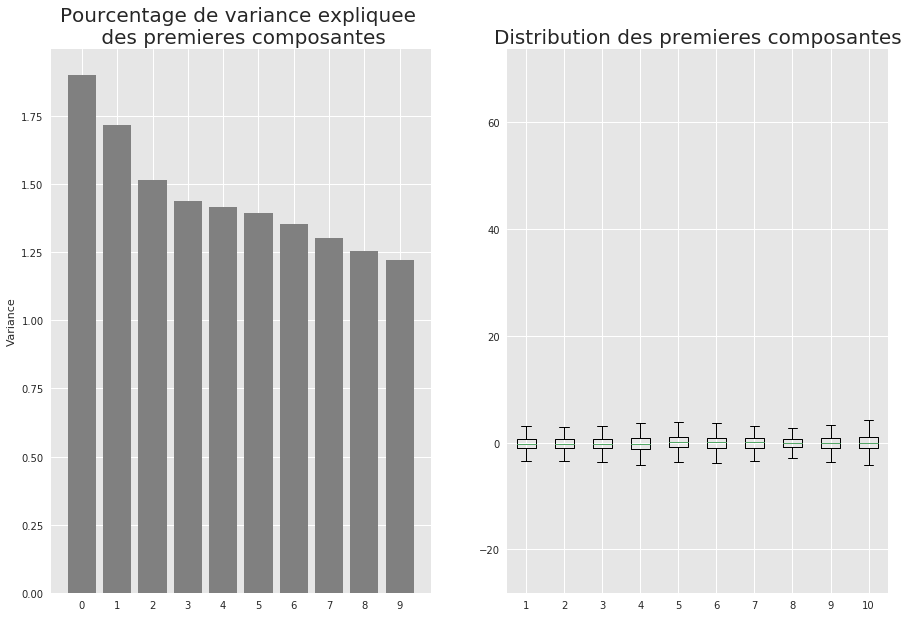

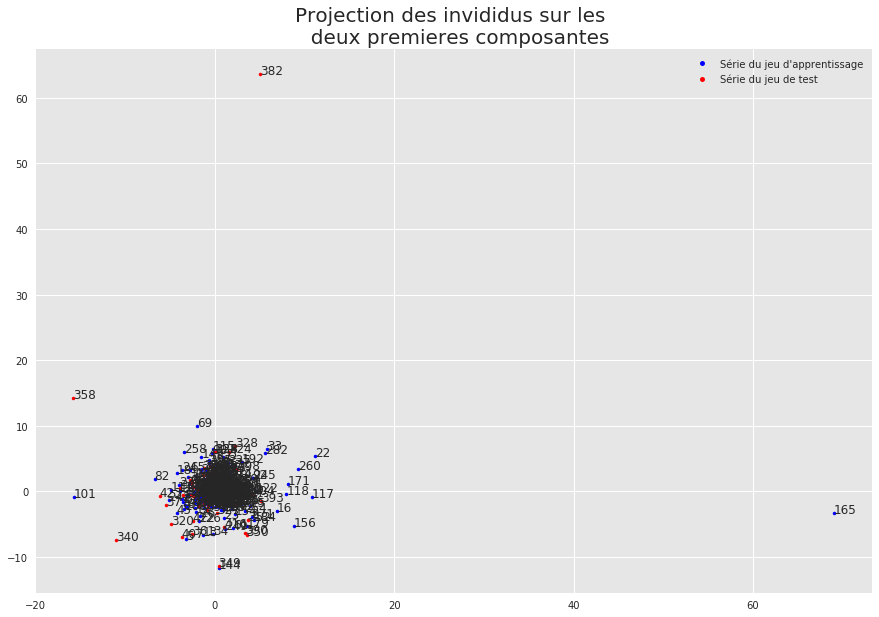

In [17]:
plot_ACP(Coeff7)

## ACP des coefficients d'ondelettes de niveau 1 à 6

In [18]:
#Coefficient de niveau 1 à 6 : 
CoeffA6=Coeff[:,:128]

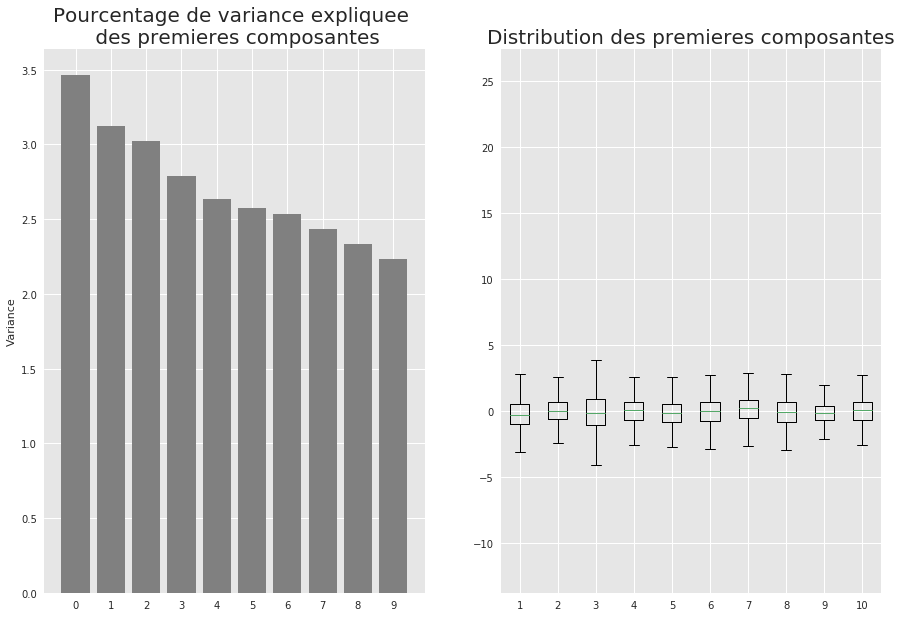

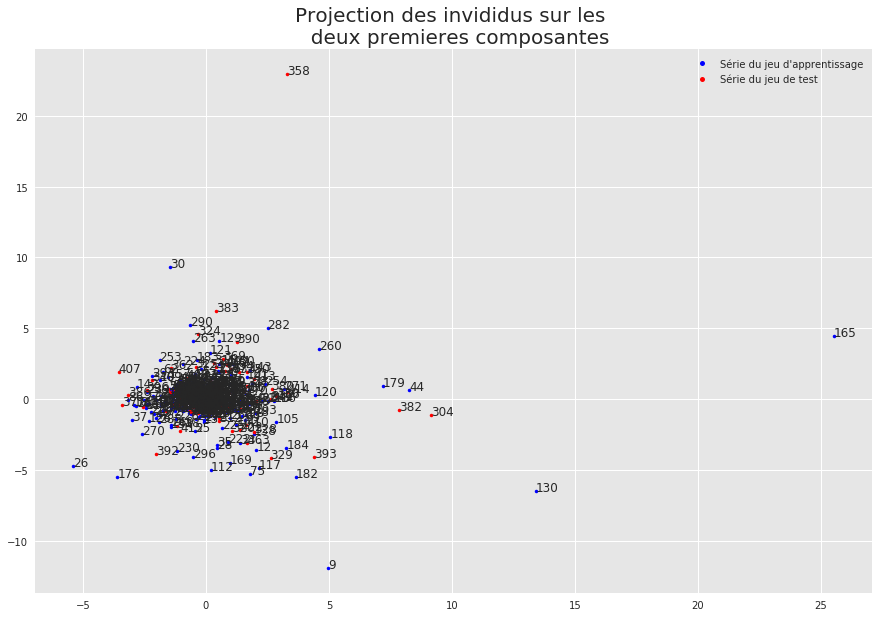

In [19]:
plot_ACP(CoeffA6)

## ACP des coefficients d'ondelettes de niveau 1 à 4

In [20]:
#Coefficient de niveau 1 à 4 : 
CoeffA4=Coeff[:,:16]

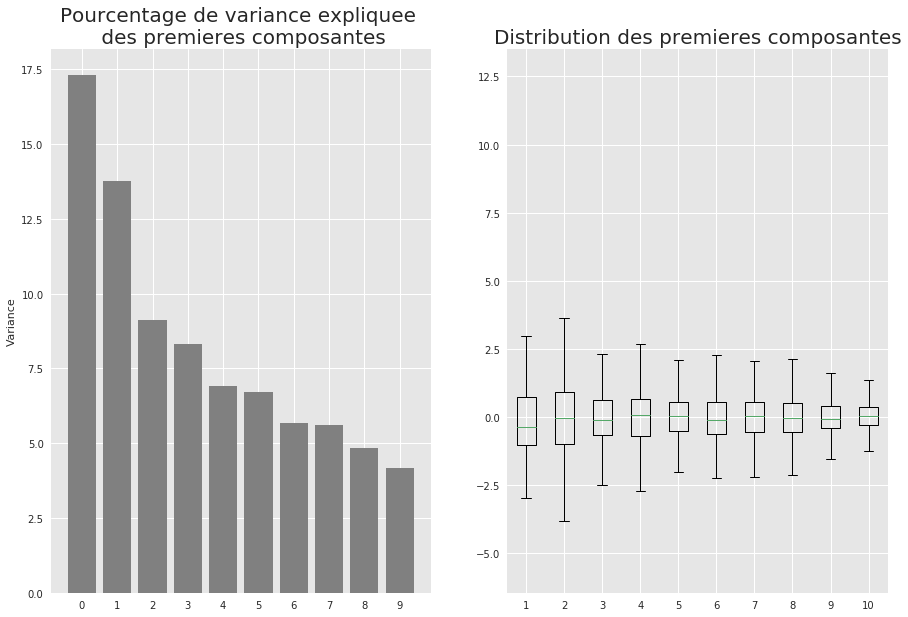

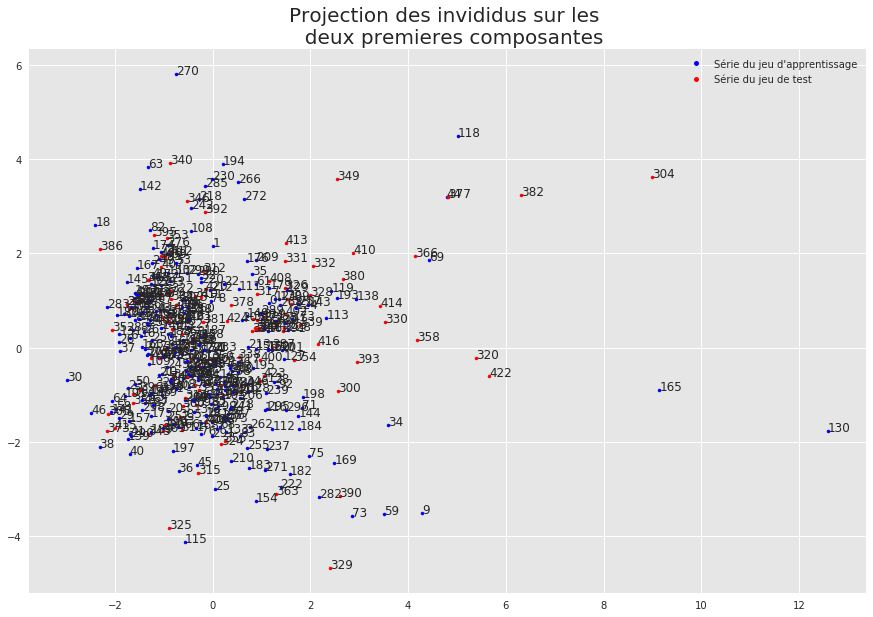

In [21]:
plot_ACP(CoeffA4)

## ACP des coefficients seuillés

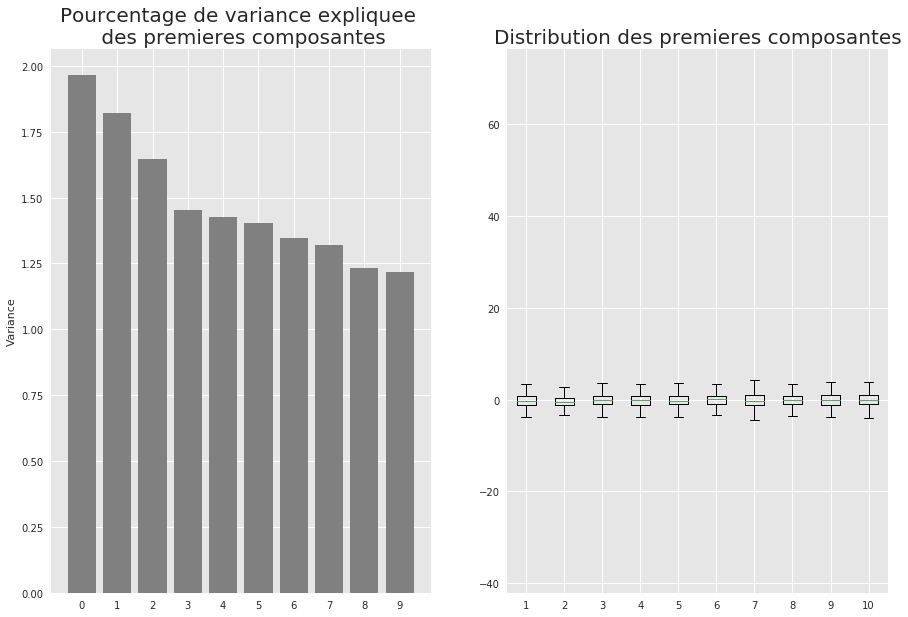

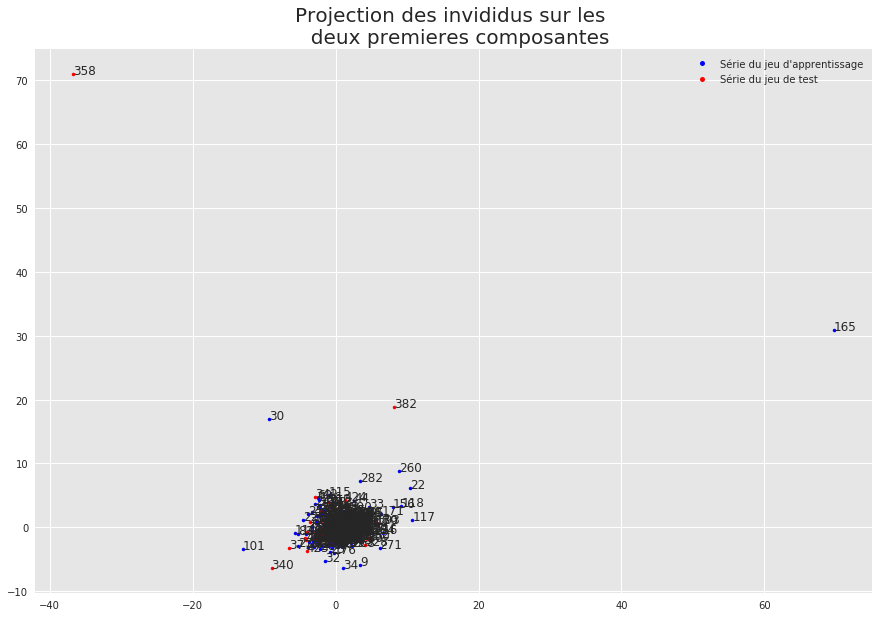

In [22]:
plot_ACP(TCoeff)

# Classification ascendante hierarchique

## Fonction d'affichage

In [23]:
def plot_CAH(Coeff):
    Z = sch.linkage(Coeff, 'single')
    C = np.array([c[0] for c in sch.cut_tree(Z,5)])
    CT = pd.DataFrame(list(C), columns=["HCA_cluster"])
    
    fig = plt.figure(figsize=(25, 10))
    sch.dendrogram( Z, p=20, leaf_rotation=45.,leaf_font_size=15, truncate_mode="level")  # font size for the x axis labels
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('sample index')
    plt.ylabel('distance')

    plt.show()

Q :DANS `dendogram`, QUEL CHOIX DE P (nb de niveaux pour l'arbre)? 

## CAH sur tous les coefficients d'ondelettes

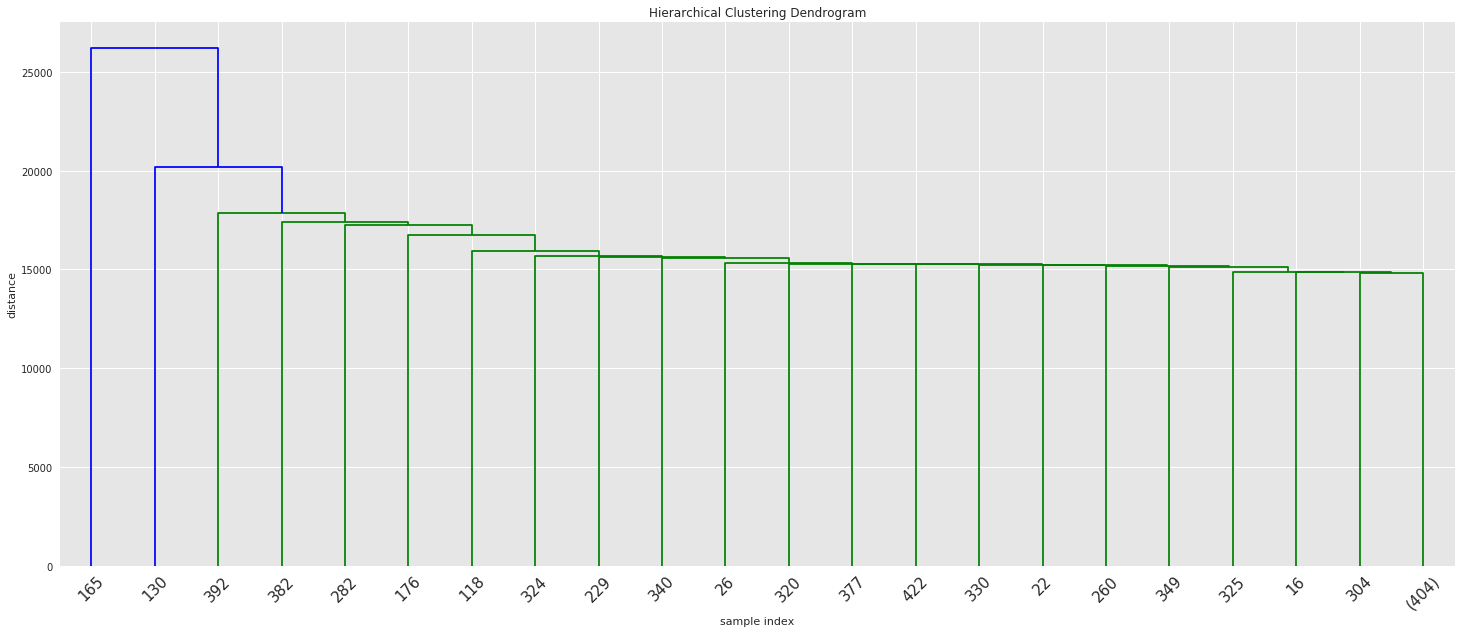

In [24]:
plot_CAH(Coeff)

## CAH sur les coefficients d'ondelettes de niveau le plus fin J=7

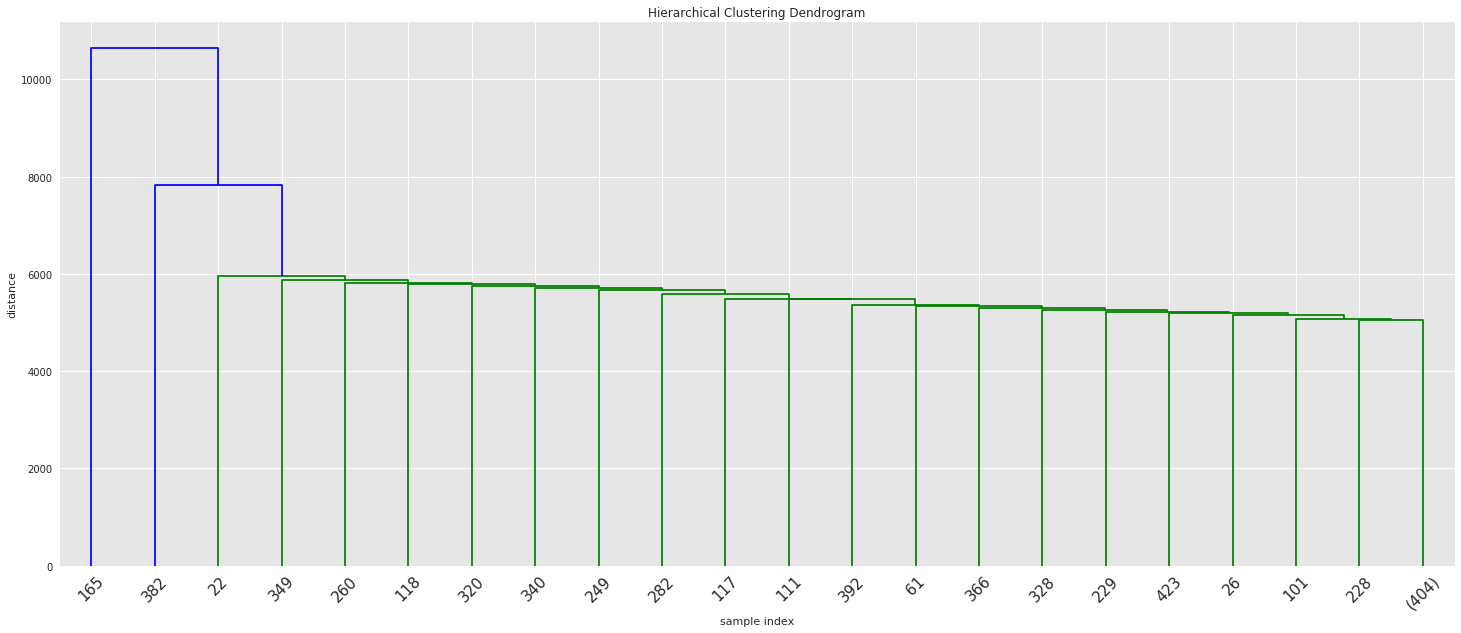

In [25]:
plot_CAH(Coeff7)

## CAH sur les coefficients d'ondelettes de niveaux 1 à 6

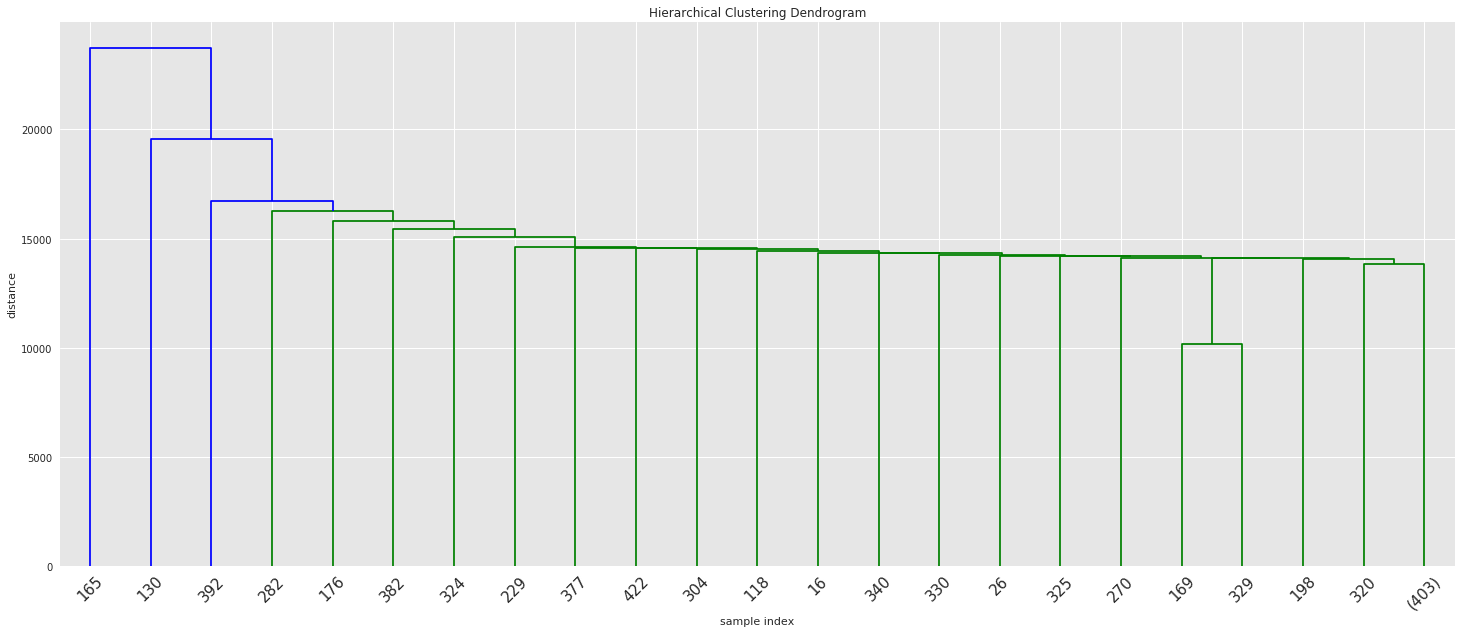

In [26]:
plot_CAH(CoeffA6)

## CAH sur les coefficients d'ondelettes de niveaux 1 à 4

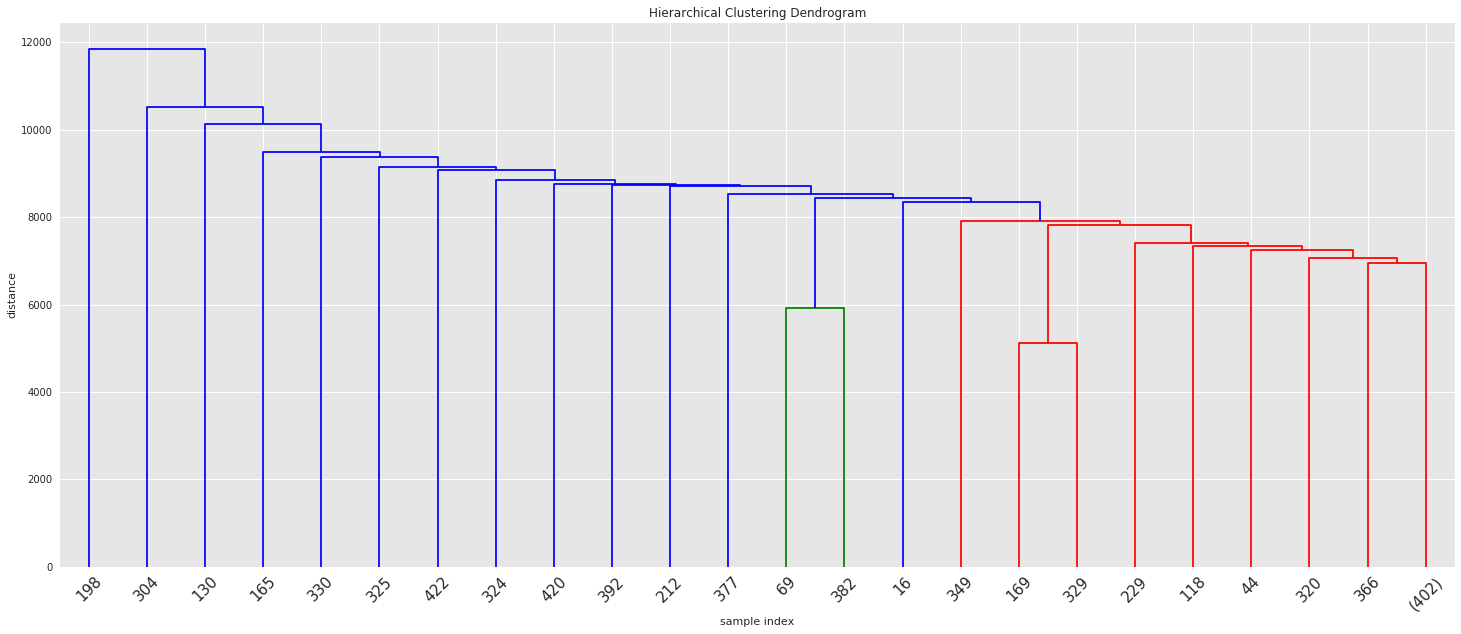

In [27]:
plot_CAH(CoeffA4)

## CAH sur les coefficients d'ondelettes seuillés

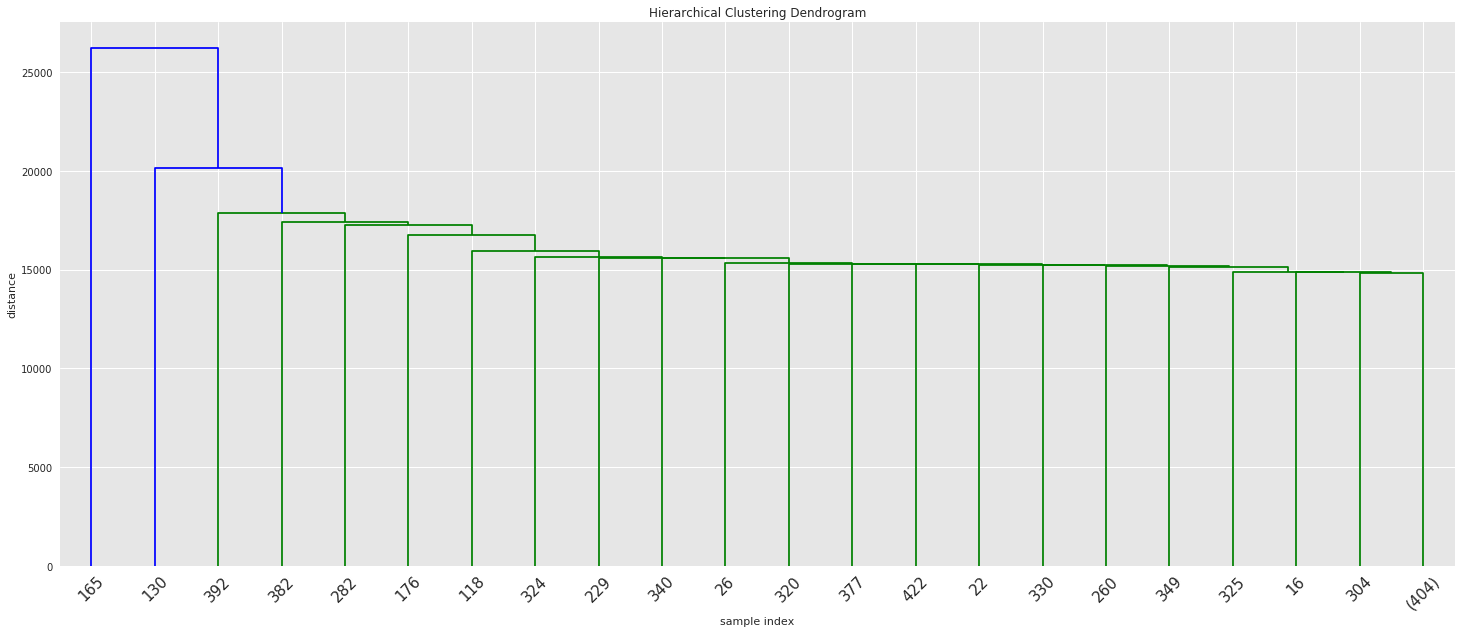

In [28]:
plot_CAH(TCoeff)

# Isolation Forest

Q : QUEL CHOIX DE `contamination` (proportion d'outliers) ?

## Isolation Forest sur tous les coefficients d'ondelettes

In [37]:
clf = se.IsolationForest(n_estimators=100, contamination=20/n, bootstrap=True, n_jobs=-1)
clf.fit(Coeff)
y_pred = clf.predict(Coeff)

CT_IF_ond = pd.DataFrame(list(y_pred), columns=["pred"])

/usr/local/insa/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


## Isolation Forest sur les coefficients d'ondelettes de niveau le plus fin J=7

In [38]:
clf = se.IsolationForest(n_estimators=100, contamination=20/n, bootstrap=True, n_jobs=-1)
clf.fit(Coeff7)
y_pred = clf.predict(Coeff7)

CT_IF_ond7 = pd.DataFrame(list(y_pred), columns=["pred"])

/usr/local/insa/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


## Isolation Forest sur les coefficients d'ondelettes de niveaux 1 à 6

In [39]:
clf = se.IsolationForest(n_estimators=100, contamination=20/n, bootstrap=True, n_jobs=-1)
clf.fit(CoeffA6)
y_pred = clf.predict(CoeffA6)

CT_IF_ondA6 = pd.DataFrame(list(y_pred), columns=["pred"])

/usr/local/insa/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


## Isolation Forest sur les coefficients d'ondelettes de niveaux 1 à 4

In [40]:
clf = se.IsolationForest(n_estimators=100, contamination=20/n, bootstrap=True, n_jobs=-1)
clf.fit(CoeffA4)
y_pred = clf.predict(CoeffA4)

CT_IF_ondA4 = pd.DataFrame(list(y_pred), columns=["pred"])

/usr/local/insa/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


## Isolation Forest sur les coefficients d'ondelettes seuillés

In [41]:
clf = se.IsolationForest(n_estimators=100, contamination=20/n, bootstrap=True, n_jobs=-1)
clf.fit(TCoeff)
y_pred = clf.predict(TCoeff)

CT_IF_ondT = pd.DataFrame(list(y_pred), columns=["pred"])

/usr/local/insa/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


## Visualistion des résultats

In [42]:
def make_figure(fig, ax, CT, legend=False):
    y_lim = (-1.13,1.13)
    x_lim = [-5,n+5]
    CT_Normal = CT[CT.pred==1]
    CT_Anomaly = CT[CT.pred==-1]
    
    ax.scatter(CT_Normal.index, - CT_Normal.pred, color="green", label="Normal")
    ax.scatter(CT_Anomaly.index, - CT_Anomaly.pred, color="red", label="Anomaly detected")
    
    #for x,y,s in zip(CT_Anomaly.index, - CT_Anomaly.pred, map(str,CT_Anomaly.index)):
    #    ax.text(x,y,s, horizontalalignment="center", verticalalignment="center", color="red")

    ax.plot(x_lim, [0,0], color="black")
    ax.set_xlim(*x_lim)
    ax.set_ylim(y_lim)
    
    if legend:
        plt.legend(bbox_to_anchor=(1,1), fontsize=20)

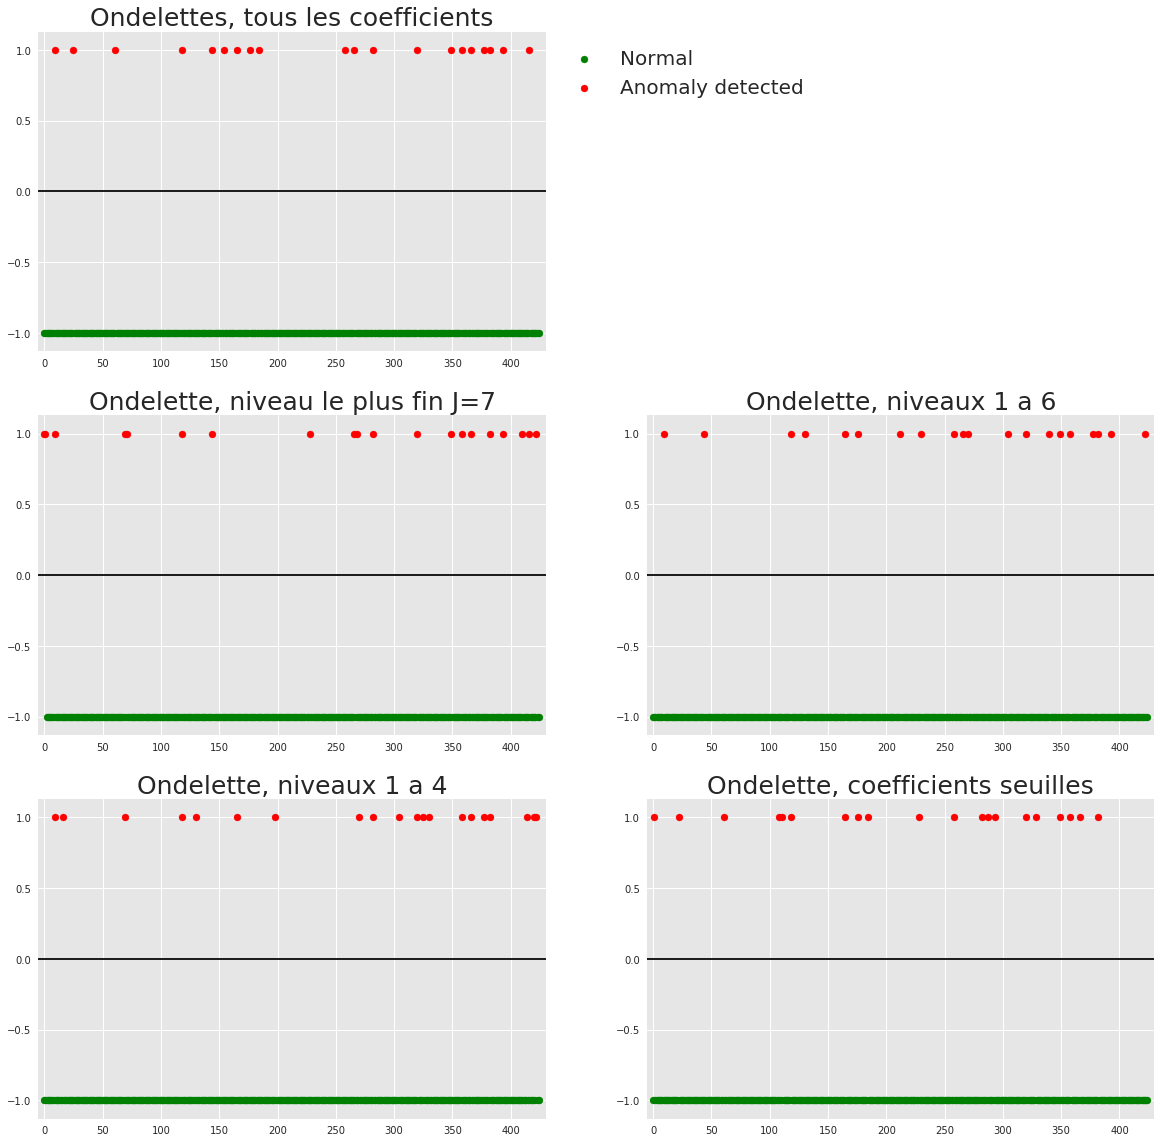

In [43]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(3,2,1)
make_figure(fig,ax,CT_IF_ond,legend=True)
ax.set_title("Ondelettes, tous les coefficients", fontsize=25)
ax = fig.add_subplot(3,2,3)
make_figure(fig,ax,CT_IF_ond7)
ax.set_title("Ondelette, niveau le plus fin J=7", fontsize=25)
ax = fig.add_subplot(3,2,4)
make_figure(fig,ax,CT_IF_ondA6)
ax.set_title("Ondelette, niveaux 1 a 6", fontsize=25)
ax = fig.add_subplot(3,2,5)
make_figure(fig,ax,CT_IF_ondA4)
ax.set_title("Ondelette, niveaux 1 a 4", fontsize=25)
ax = fig.add_subplot(3,2,6)
make_figure(fig,ax,CT_IF_ondT)
ax.set_title("Ondelette, coefficients seuilles", fontsize=25)
plt.show()

In [44]:
print("Anomalies avec tous les coefficients : ", CT_IF_ond[CT_IF_ond.pred==-1].index.values)
print("Anomalies avec coefficients de niveau le plus fin J=7: ", CT_IF_ond7[CT_IF_ond7.pred==-1].index.values)
print("Anomalies avec coefficients de niveaux 1 à 6: ", CT_IF_ondA6[CT_IF_ondA6.pred==-1].index.values)
print("Anomalies avec coefficients de niveaux 1 à 4: ", CT_IF_ondA4[CT_IF_ondA4.pred==-1].index.values)
print("Anomalies avec coefficients seuillés: ", CT_IF_ondT[CT_IF_ondT.pred==-1].index.values)

Anomalies avec tous les coefficients :  [  9  25  61 118 144 154 165 176 184 258 266 282 320 349 358 366 377 382
 393 416]
Anomalies avec coefficients de niveau le plus fin J=7:  [  0   1   9  69  71 118 144 228 266 268 282 320 349 358 366 382 393 410
 416 422]
Anomalies avec coefficients de niveaux 1 à 6:  [  9  44 118 130 165 176 212 230 258 266 270 304 320 340 349 358 377 382
 393 422]
Anomalies avec coefficients de niveaux 1 à 4:  [  9  16  69 118 130 165 198 270 282 304 320 325 330 358 366 377 382 414
 420 422]
Anomalies avec coefficients seuillés:  [  1  22  61 108 111 118 165 176 184 228 258 282 287 293 320 328 349 358
 366 382]


## One Class SVM

In [46]:
def plot_OCSVM(Coeff):
    OCS = ssvm.OneClassSVM(nu=20/n)

    OCS.fit(Coeff)
    pred = OCS.predict(Coeff)

    CT_svm_ACP = pd.DataFrame(list(pred), columns=["pred"])
    
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(1,1,1)
    make_figure(fig,ax,CT_svm_ACP)

### Avec les coefficients dans la base des composantes principales

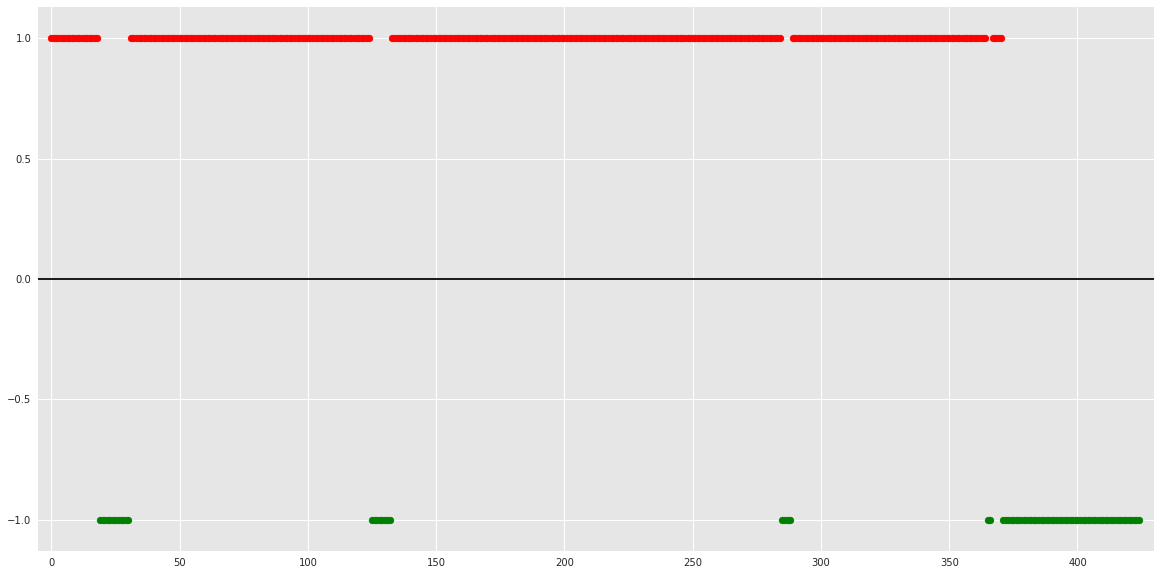

In [47]:
plot_OCSVM(Coeff)

### Avec les coefficients d'ondelettes de niveau le plus fin J=7

### Avec les coefficients d'ondelettes de niveau 1 à 6

### Avec les coefficients d'ondelettes de niveau 1 à 4

### Avec les coefficients d'ondelettes seuillés